In [5]:
!pip install control

     |████████████████████████████████| 357 kB 634 kB/s eta 0:00:01
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364696 sha256=b11fee18ddfd55d7b35a7b47d7ba85da8c5574f98347af38972a209a32ed9561
  Stored in directory: /home/benitez/.cache/pip/wheels/6e/8e/71/ee16865ba735139c6b4b9581a60028b7bf63468071ee308cb1
Successfully built control


In [1]:
from pylab import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import control
from time import sleep
import math


import SoapySDR as sp


In [66]:


sample_rate = 2e6
center_freq = 0.5e6



In [67]:
args = dict(driver="sdrplay")
sdr = sp.Device(args)

In [68]:
def fazer_aquisicao(sample_rate, center_freq, gain, nsamples):
    if sample_rate < 1e6:
        print("sample_rate precisa estar entre 1e6 e 2e6")
        return
    if gain < 1:
        print("gain precisa ser maior igual a 1")
   
    args = dict(driver="sdrplay")
    sdr = sp.Device(args)
    rx_chan = 0
    gain = 42 - gain
    sdr.setSampleRate(sp.SOAPY_SDR_RX, rx_chan, sample_rate)
    sdr.setFrequency(sp.SOAPY_SDR_RX, rx_chan, center_freq)
    sdr.setGainMode(sp.SOAPY_SDR_RX, rx_chan, False) # turn off AGC
    sdr.setGain(sp.SOAPY_SDR_RX, rx_chan, gain)
   
    max_nsamples = 32256
    rodadas = 1
    if nsamples > max_nsamples:
        rodadas = math.ceil(nsamples/max_nsamples)

    print("[INFO]Para", nsamples, "serão feitas", rodadas, "medidas")
    rxStream = sdr.setupStream(sp.SOAPY_SDR_RX, sp.SOAPY_SDR_CF32)
    print("faxa de ganho")
    print(sdr.getGainRange(sp.SOAPY_SDR_RX, rx_chan))
    
    print("[DONE]setup")
    
    sdr.activateStream(rxStream) #start streaming
    print("[DONE]activateStream")
    
    _samples = np.array([0]*max_nsamples, np.complex64)
    samples = np.array([], np.complex64)
    mperdidas = 0;
    for j in range(rodadas):        
        for i in range(20):
            sr = sdr.readStream(rxStream, [_samples], len(_samples))
            if sr.ret > 0:                
                break
            if i == 19:
                mperdidas = mperdidas + 1
                print("[ERROR]readStream", sr.ret)
                print("[INFO]", mperdidas, "/", rodadas, "medidas perdidas")
                break
        samples = np.concatenate([samples, _samples])
    sdr.deactivateStream(rxStream) #stop streaming
    sdr.closeStream(rxStream)
    sleep(1)
    print("[DONE]fechou")
    return samples

def fazer_grafico(samples, sample_rate, center_freq):
    if sample_rate < 1e6:
        print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        print("center_freq precisa ser maior igual a 1e6")
        return    
    NFFT = 1024
    plt.figure()
    plt.psd(samples, NFFT=NFFT, Fs=sample_rate/1e6, Fc=center_freq/1e6, color='crimson')    
    
    xlabel('Frequency (MHz)')
    ylabel('Relative power (dB)') 
    #plt.savefig("psd.png")
    
def obter_magnitude(freq, samples, sample_rate, center_freq):
    if sample_rate < 1e6:
        print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        print("center_freq precisa ser maior igual a 1e6")
        return
    sample_rate = sample_rate/1e6
    center_freq = center_freq/1e6
    freq = freq/1e6
    NFFT = 1024
    axes = psd(samples, NFFT=NFFT, Fs=sample_rate)
    y = 10*np.log10(axes[0])
    x = axes[1] + center_freq
    i = find_nearest(x, freq)    
    return x[i],y[i]

def find_nearest(array, value):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def obter_magnitude_sem_ganho(mag, ganho):
    amp = control.db2mag(mag)/ganho
    return 20*np.log10(amp)

2

[INFO]Para 1024 serão feitas 1 medidas
faxa de ganho
0, 42
[DONE]setup


[INFO] Using format CF32.


[DONE]activateStream
[DONE]fechou
triagular_20khz_a_sr=2e6;cf=100e3


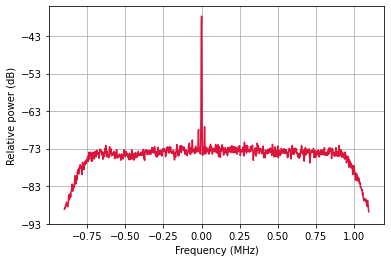

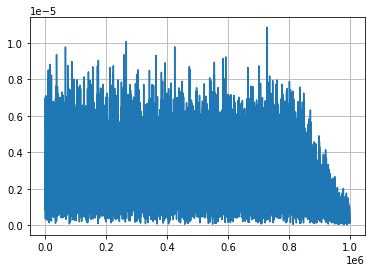

In [150]:
sample_rate = 2e6
center_freq = 0.1e6

samples = fazer_aquisicao(
    sample_rate = sample_rate,
    center_freq = center_freq,
    gain = 1,
    nsamples = 1024
)

NFFT = 1024
plt.figure()
plt.psd(samples, NFFT=NFFT, Fs=sample_rate/1e6, Fc=center_freq/1e6, color='crimson')    

xlabel('Frequency (MHz)')
ylabel('Relative power (dB)')



name = f'triagular_20khz_a_sr={int(sample_rate/1e6)}e6;cf={int(center_freq/1e3)}e3'
print(name)
np.save(f'measurements/{name}.npy', samples)
plt.savefig(f'measurements/{name}.png')

def plot_fft(x:np.array, fs:int):
    plt.figure()
    N = x.shape[0]
    T = 1/fs
    f = fft(x)
    xf = fftfreq(N, T)[:N//2]
    
    plt.plot(xf, 2.0/N * np.abs(f[0:N//2]))
    plt.grid()
plot_fft(samples, fs=sample_rate)

In [127]:
samples

array([ 0.0000000e+00+0.j        , -3.0517578e-05+0.j        ,
        6.1035156e-05+0.j        , ...,  1.1596680e-03-0.00024414j,
        5.4931641e-04-0.00054932j,  1.8310547e-04-0.00054932j],
      dtype=complex64)

In [69]:
samples = fazer_aquisicao(
    sample_rate = sample_rate,
    center_freq = center_freq,
    gain = 1,
    nsamples = 1024
)
fazer_grafico(
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
freq, mag = obter_magnitude(
    freq = center_freq,
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
print("Na frequência", freq, "a magnitude é de", mag, "dB")

name = 'triagular_59hz_a'
np.save(f'measurements/{name}.npy', samples)
plt.savefig(f'measurements/{name}.png')



[INFO]Para 1024 serão feitas 1 medidas
faxa de ganho
0, 42
[DONE]setup


[INFO] Using format CF32.


[DONE]activateStream
[DONE]fechou
center_freq precisa ser maior igual a 1e6
center_freq precisa ser maior igual a 1e6


TypeError: cannot unpack non-iterable NoneType object

<Figure size 432x288 with 0 Axes>

In [29]:
#samples_loaded = np.load('measurements/triagular_100khz_a.npy')